# Iterative Linear Quadratic Regulator

In [ ]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

/content/jupyter_setup.py:13: UserWarning: jupyter_setup.py is deprecated.  Please use setup_underactuated_colab.py instead.
  warnings.warn("jupyter_setup.py is deprecated.  Please use"


Cloning into '/opt/underactuated'...

HEAD is now at 2a15bde minor reword on exercise 7.2 (#428)

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






In [ ]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# pydrake imports
from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial)
import pydrake.symbolic as sym

In [ ]:
"""
https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

tip = sin, cos
side = (-cos, sin)

side engines

ox = - cos * (-1 if left else 1) * dist_thruster_to_center
oy = - sin * (-1 if left else 1) * dist_thruster_to_center

main engine

ox = sin * dist_thruster_to_center - cos * 0
oy = -cos * dist_thruster_to_center - sin * 0
"""

'\nhttps://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py\n\ntip = sin, cos\nside = (-cos, sin)\n\nside engines\n\nox = - cos * (-1 if left else 1) * dist_thruster_to_center\noy = - sin * (-1 if left else 1) * dist_thruster_to_center\n\nmain engine\n\nox = sin * dist_thruster_to_center - cos * 0\noy = -cos * dist_thruster_to_center - sin * 0\n'

In [ ]:
n_x = 6
n_u = 3
# NOTE: gravity below is for moon's gravity 
gravity = 9.81
# Rectangle is b x h

# control_limits = [8 * mass, 8 * mass, gravity * mass * 8]

def sigmoid(x, m): # squashes from 0 to 1
    return 1 / (1 + m.exp(-x))

mass = 5000
control_limits = [0.6 * mass * gravity, 0.6 * mass * gravity, gravity * mass * 5]
w = 34
h = 28

box_poly = [(w/2, h/2),
            (-w/2, h/2),
            (-w/2, -h/2),
            (w/2, -h/2)]
box_poly = np.array(box_poly)

moment_I = (1/12) * w*h*(w*w + h*h) * mass
eng_points = [(w/2, h/2), (-w/2, h/2), (0, -h/2)]
eng_dirs = [(-1, 0), (1, 0), (0, 1)]
center = (0, 0)

def car_continuous_dynamics(x, u, squashed_control_inputs=False):
    # x = [x position, x velocity, y position, y velocity, angle, angular velocity] 
    # u = [u_l, u_r, u_u]
    m = sym if x.dtype == object else np # Check type for autodiff
    u_l, u_r, u_u = u[0], u[1], u[2]
    # squashing as suggested by https://github.com/anassinator/ilqr/issues/11
    if not squashed_control_inputs:
        u_l = sigmoid(u_l, m) 
        u_r = sigmoid(u_r, m) 
        u_u = sigmoid(u_u, m) 
    controls = [u_l, u_r, u_u]
    eng_forces = [controls[i] * control_limits[i] for i in range(3)]
    t = x[4]
    x_d = np.array([
        x[1],
        0, # x acceleration
        x[3],
        -gravity, # y acceleration
        x[5],
        0 # ==> sum of torque = -u_l*h/2 + u_r*h/2 = I * alpha = (b*h*(b**2 + h**2))/12 * alpha
    ])
    s, c = (m.sin(t), m.cos(t))
    def rotate_vec(start_vec):
        return (start_vec[0] * c - start_vec[1] * s, start_vec[0] * s + start_vec[1] * c)
    # print(f"t = {t}")
    for i in range(3):
        f_local = eng_forces[i]
        appl_point = eng_points[i]
        # print(i, appl_point, "appl point")
        appl_dir = eng_dirs[i] # local frame of ref
        appl_dir_rot = rotate_vec(appl_dir) # global frame of ref

        force_vec = (appl_dir_rot[0] * f_local, appl_dir_rot[1] * f_local)
        center_to_eng = (appl_point[0] - center[0], appl_point[1] - center[1])
        eng_to_center = (center[0] - appl_point[0], center[1] - appl_point[1])

        center_to_eng_rot = rotate_vec(center_to_eng)
        eng_to_center_rot = rotate_vec(eng_to_center)
        # print(eng_to_center_rot[0]**2 + eng_to_center_rot[1]**2)
        # print(i, eng_to_center_rot, "engine to center rotated")
        # print(i, appl_dir_rot, "appl_dir_rot")
        # print(i, force_vec, "force_vec")
        proj_scale = force_vec[0] * eng_to_center_rot[0] + force_vec[1] * eng_to_center_rot[1]
        proj_scale /= eng_to_center_rot[0] * eng_to_center_rot[0] + eng_to_center_rot[1] * eng_to_center_rot[1]
        proj = (eng_to_center_rot[0] * proj_scale, eng_to_center_rot[1] * proj_scale)
        # print(i, proj, "b")
        cross = center_to_eng_rot[0] * force_vec[1] - center_to_eng_rot[1] * force_vec[0]
        x_d[1] += proj[0]/mass
        x_d[3] += proj[1]/mass
        x_d[5] += cross/moment_I
    # print(x_d)
    return x_d

Note that while the vehicle dynamics are in continuous time, our problem formulation is in discrete time. Define the general discrete time dynamics $\bf f$ with a simple [Euler integrator](https://en.wikipedia.org/wiki/Euler_method) in the next cell.

In [ ]:
def discrete_dynamics(x, u, squashed_control_inputs=False):
    dt = 0.01
    # TODO: Fill in the Euler integrator below and return the next state
    x_next = x + car_continuous_dynamics(x, u, squashed_control_inputs) * dt
    return x_next

Given an initial state $\mathbf{x}_0$ and a guess of a control trajectory $\mathbf{u}[0:N-1]$ we roll out the state trajectory $x[0:N]$ until the time horizon $N$. Please complete the rollout function.

In [ ]:
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0]+1, x0.shape[0]))
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    x_trj[0] = x0
    for n in range(x_trj.shape[0] - 1):
        x = x_trj[n]
        x_next = discrete_dynamics(x, u_trj[n])
        x_trj[n + 1] = x_next
    return x_trj

# Debug your implementation with this example code
N = 10
x0 = np.array([1, 0, 10, -0.1, 1, 0])
u_trj = np.zeros((N-1, n_u))
u_trj -= 10e20
x_trj = rollout(x0, u_trj)
print(x_trj)

[[ 1.        0.       10.       -0.1       1.        0.      ]
 [ 1.        0.        9.999    -0.1981    1.        0.      ]
 [ 1.        0.        9.997019 -0.2962    1.        0.      ]
 [ 1.        0.        9.994057 -0.3943    1.        0.      ]
 [ 1.        0.        9.990114 -0.4924    1.        0.      ]
 [ 1.        0.        9.98519  -0.5905    1.        0.      ]
 [ 1.        0.        9.979285 -0.6886    1.        0.      ]
 [ 1.        0.        9.972399 -0.7867    1.        0.      ]
 [ 1.        0.        9.964532 -0.8848    1.        0.      ]
 [ 1.        0.        9.955684 -0.9829    1.        0.      ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


We define the stage cost function $\ell$ and final cost function $\ell_f$. The goal of these cost functions is to drive the vehicle along a circle with radius $r$ around the origin with a desired speed.

In [ ]:
dest = [0, 0]

In [ ]:
eps = 1e-6 # The derivative of sqrt(x) at x=0 is undefined. Avoid by subtle smoothing
def cost_stage(x, u):
    # x = [x position, x velocity, y position, y velocity, angle, angular velocity] 
    # u = [u_l, u_r, u_u]
    m = sym if x.dtype == object else np # Check type for autodiff
    c_dest = 3*((x[0] - dest[0])**2 + (x[2] - dest[1] - h/2)**2)/(x[2]+eps)
    # c_dest += -x[2]
    c_vel = (x[3]**2)*1
    # c_vel = 0

    u_l, u_r, u_u = u[0], u[1], u[2]
    # squashing as suggested by https://github.com/anassinator/ilqr/issues/11
    u_l = sigmoid(u_l, m) 
    u_r = sigmoid(u_r, m) 
    u_u = sigmoid(u_u, m) 
    c_test = (1 - u_u) * (x[0] - dest[0])**2
    c_control =  0.3 * (u_u**2)
    u_l *= control_limits[0] 
    u_r *= control_limits[1] 
    u_u *= control_limits[2] 
    # c_control = 0
    c_landing = x[4]**2 * 1000
    c_landing = 0
    c_l_r_thrust = (x[0] - dest[0]) * (u_l - u_r) * 0.01
    c_l_r_thrust = 0

    return c_dest + c_vel + c_control + c_landing + c_l_r_thrust

def cost_final(x):
    m = sym if x.dtype == object else np # Check type for autodiff
    c_dest = 5 * m.sqrt((x[0] - dest[0])**2 + (x[2] - dest[1])**2 + x[4]**2 + eps)
    c_vel = 1*(x[1]**2 + x[3]**2)
    c_landing = 0
    return 0

Your next task is to write the total cost function of the state and control trajectory. This is simply the sum of all stages over the control horizon and the objective from general problem formulation above.

In [ ]:
def cost_trj(x_trj, u_trj):
    total = 0.0
    for n in range(u_trj.shape[0]):
        x = x_trj[n]
        u = u_trj[n]
        total += cost_stage(x, u)
    total += cost_final(x_trj[-1])
    return total
    
# Debug your code
cost_trj(x_trj, u_trj)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


49.00575353904366

# Heuristic Method

In [ ]:
def heuristic(s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.

    Args:
        s (list): The state. Attributes:
                  s[0] is the horizontal coordinate
                  s[1] is the horizontal speed
                  s[2] is the vertical coordinate
                  s[3] is the vertical speed
                  s[4] is the angle
                  s[5] is the angular speed
    returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0]*0.5 + s[1]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    # print(angle_todo)
    hover_todo = (hover_targ - s[2])*0.5 - (s[3])*0.5
    hover_todo *= 20
    angle_todo *= 10
    u_u = hover_todo
    if angle_todo < 0:
        u_r = abs(angle_todo)
        u_l = 0
    else:
        u_l = abs(angle_todo)
        u_r = 0

    a = np.array([u_l, u_r, u_u])
    a = np.clip(a, 0, 1)
    return a

In [ ]:
def get_heuristic_trj(x0, N):
    x_trj = np.zeros((N, len(x0)))
    u_trj = np.zeros((N-1, n_u))
    x_trj[0] = x0
    for i in range(1, N):
        u_trj[i-1] = heuristic(x_trj[i-1])
        x_trj[i] = discrete_dynamics(x_trj[i-1], u_trj[i-1], True)
    return x_trj, u_trj

13.97645454482467
1685


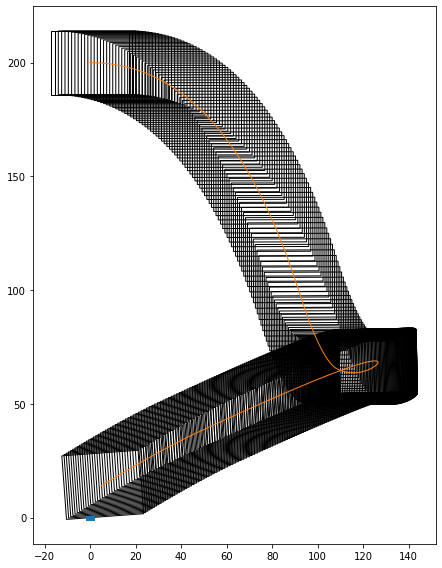

In [ ]:
x0s = [np.array([dest[0], 30, 200, 0, 0, 0])]
for x0 in x0s:
# x0 = x0s[0]
    N = 2500
    x_trj, u_trj = get_heuristic_trj(x0, N)
    end = N - 1
    for n in range(N):
        if x_trj[n, 2] < dest[1] + h/2:
            print(x_trj[n, 2])
            end = n + 1
            break
    # print(u_trj)
    # end = N
    print(end)
    plt.figure(figsize=(9.5,8))
    # Plot circle
    helipad_x = np.linspace(-1, 1, 50) + dest[0]
    helipad_y = np.zeros(helipad_x.shape) + dest[1]
    plt.plot(helipad_x, helipad_y, linewidth=5)
    ax = plt.gca()

    # Plot resulting trajecotry of car
    plt.plot(x_trj[:end,0], x_trj[:end,2], linewidth=1)
    # Plot rectangles
    for n in range(0, end, 5):
        rect = mpl.patches.Rectangle((-w/2,-h/2), w, h, fill=False)
        t = mpl.transforms.Affine2D().rotate(x_trj[n,4]).translate(x_trj[n,0], x_trj[n,2]) + ax.transData
        rect.set_transform(t)
        ax.add_patch(rect)
    ax.set_aspect(1)
    #plt.ylim((-3, 15))
    #plt.xlim((-5, 5))
    plt.tight_layout()
    plt.show()

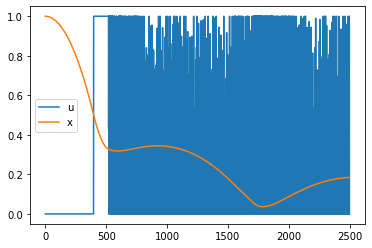

In [ ]:
plt.plot(u_trj[:, 2], label='u')
plt.plot(x_trj[:, 2]/np.max(np.abs(x_trj[:, 2])), label='x')
plt.legend()
plt.show()

In [ ]:
u_trj

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
# asdf

# iLQR

In [ ]:
class derivatives():
    def __init__(self, discrete_dynamics, cost_stage, cost_final, n_x, n_u):
        self.x_sym = np.array([sym.Variable("x_{}".format(i)) for i in range(n_x)])
        self.u_sym = np.array([sym.Variable("u_{}".format(i)) for i in range(n_u)])
        x = self.x_sym
        u = self.u_sym
        
        l = cost_stage(x, u)
        self.l_x = sym.Jacobian([l], x).ravel()
        self.l_u = sym.Jacobian([l], u).ravel()
        self.l_xx = sym.Jacobian(self.l_x, x)
        self.l_ux = sym.Jacobian(self.l_u, x)
        self.l_uu = sym.Jacobian(self.l_u, u)
        
        l_final = cost_final(x)
        self.l_final_x = sym.Jacobian([l_final], x).ravel()
        self.l_final_xx = sym.Jacobian(self.l_final_x, x)
        
        f = discrete_dynamics(x, u)
        self.f_x = sym.Jacobian(f, x)
        self.f_u = sym.Jacobian(f, u)
    
    def stage(self, x, u):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        env.update({self.u_sym[i]: u[i] for i in range(u.shape[0])})
        
        l_x = sym.Evaluate(self.l_x, env).ravel()
        l_u = sym.Evaluate(self.l_u, env).ravel()
        l_xx = sym.Evaluate(self.l_xx, env)
        l_ux = sym.Evaluate(self.l_ux, env)
        l_uu = sym.Evaluate(self.l_uu, env)
        
        f_x = sym.Evaluate(self.f_x, env)
        f_u = sym.Evaluate(self.f_u, env)

        return l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u
    
    def final(self, x):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        
        l_final_x = sym.Evaluate(self.l_final_x, env).ravel()
        l_final_xx = sym.Evaluate(self.l_final_xx, env)
        
        return l_final_x, l_final_xx
        
derivs = derivatives(discrete_dynamics, cost_stage, cost_final, n_x, n_u)
# Test the output:
x = np.array([0, 0, 0, 0, 0, 0])
u = np.array([0, 0, 0])
print(derivs.stage(x, u))
print(derivs.final(x))

(array([ 0.00000000e+00,  0.00000000e+00, -5.88000084e+14,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00]), array([0.   , 0.   , 0.075]), array([[6.00000000e+06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.17600017e+21, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]]), array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]]), array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
    

In [ ]:
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = l_x + np.dot(f_x.T, V_x)
    Q_u = l_u + np.dot(f_u.T, V_x)
    Q_xx = l_xx + np.dot(np.dot(f_x.T, V_xx), f_x)
    Q_ux = l_ux + np.dot(np.dot(f_u.T, V_xx), f_x)
    Q_uu = l_uu + np.dot(np.dot(f_u.T, V_xx), f_u)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [ ]:
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    # TODO: Implement the feedforward gain k and feedback gain K.
    k = -np.dot(Q_uu_inv, Q_u.T)
    K = -np.dot(Q_uu_inv, Q_ux)
    return k, K

In [ ]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x = (Q_x + np.dot(Q_u, K)) + (np.dot(k.T, Q_ux) + np.dot(Q_ux.T, k) + np.dot(k.T, (np.dot(Q_uu.T, K)))) + np.dot(K.T, (np.dot(Q_uu.T, k)))
    V_xx = Q_xx + np.dot(K.T, Q_ux) + np.dot(Q_ux.T, K) + np.dot(K.T, (np.dot(Q_uu.T, K)))
    return V_x, V_xx

### Expected Cost Reduction
We can also estimate by how much we expect to reduce the cost by applying the optimal controls. Simply subtract the previous nominal Q-value ($\delta \mathbf{x}[n] = 0$ and $\delta \mathbf{u}[n]=0$) from the value function.  The result is implemented below and is a useful aid in checking how accurate the quadratic approximation is during convergence of iLQR and adapting stepsize and regularization.

In [ ]:
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

### Forward Pass
We have now have all the ingredients to implement the forward pass and the backward pass of iLQR. In the forward pass, at each timestep the new updated control $\mathbf{u}' =  \bar{\mathbf{u}} + k + K (x' - \bar{\mathbf{x}})$ is applied and the dynamis propagated based on the updated control. The nominal control and state trajectory $\bar{\mathbf{u}}, \bar{\mathbf{x}}$ with which we computed $k$ and $K$ are then updated and we receive a new set of state and control trajectories.

In [ ]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0, :] = x_trj[0, :]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]):
        u_trj_new[n, :] = u_trj[n] + k_trj[n] + np.dot(K_trj[n], x_trj_new[n] - x_trj[n])
        x_trj_new[n+1, :] = discrete_dynamics(x_trj_new[n], u_trj_new[n])
    return x_trj_new, u_trj_new

### Backward Pass
The backward pass starts from the terminal boundary condition $V(\mathbf{x}[N]) =   \ell_f(\mathbf{x}[N])$, such that $V_{\mathbf{x},N} = \ell_{\mathbf{x},f}$ and $V_{\mathbf{xx},N} = \ell_{\mathbf{xx},f}$. In the backwards loop terms for the Q-function at $n$ are computed based on the quadratic value function approximation at $n+1$ and the derivatives and hessians of dynamics and cost functions at $n$. To solve for the gains $k$ and $K$ an inversion of the matrix $Q_\mathbf{uu}$ is necessary. To ensure invertability and to improve conditioning we add a diagonal matrix to $Q_\mathbf{uu}$. This is equivalent to adding a quadratic penalty on the distance of the new control trajectory from the control trajectory of the previous iteration. The result is a smaller stepsize and more conservative convergence properties.

In [ ]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)
    V_x = np.zeros((x_trj.shape[1],))
    V_xx = np.zeros((x_trj.shape[1],x_trj.shape[1]))
    N = x_trj.shape[0] - 1
    l_final_x, l_final_xx = derivs.final(x_trj[N])
    V_x = l_final_x
    V_xx = l_final_xx
    # print("no error")
    for n in range(u_trj.shape[0]-1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms
        x = x_trj[n]
        u = u_trj[n]
        l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x, u)
        # print(f_u)
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
        # print(Q_uu)
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

### Main Loop

The main iLQR loop consists of iteratively applying the forward and backward pass. The regularization is adapted based on whether the new control and state trajectories improved the cost. We lower the regularization if the total cost was reduced and accept the new trajectory pair. If the total cost did not decrease, the trajectory pair is rejected and the regularization is increased. You may want to test the algorithm with deactivated regularization and observe the changed behavior.
The main loop stops if the maximum number of iterations is reached or the expected reduction is below a certain threshold.

If you have correctly implemented all subparts of the iLQR you should see that the car plans to drive around the circle.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


[10, 7.0, 4.8999999999999995, 3.4299999999999993, 6.8599999999999985, 13.719999999999997]
13.923426434343499
end = 1671


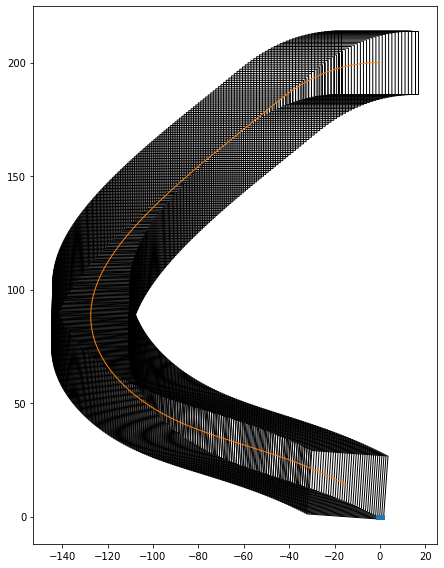

[[-1.08004e+01  7.86830e+00 -9.78610e+00]
 [-1.07713e+01  7.86640e+00 -9.73160e+00]
 [-1.07425e+01  7.86440e+00 -9.67700e+00]
 ...
 [ 4.71700e-01  5.49400e-01 -5.36320e+00]
 [ 2.38800e-01  2.78600e-01 -3.06500e+00]
 [ 1.00000e-04  1.00000e-04 -3.31000e-02]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


[10, 7.0, 4.8999999999999995, 9.799999999999999]
13.922978262148359
end = 903


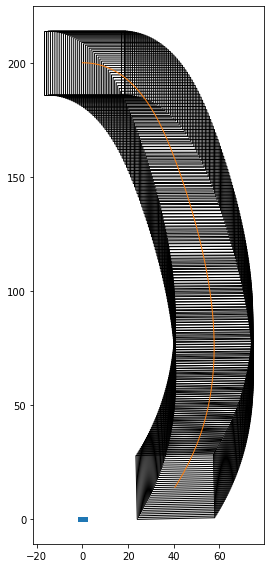

[[ 6.4480e+00 -3.4099e+00 -9.7039e+00]
 [ 6.4392e+00 -3.4410e+00 -9.6501e+00]
 [ 6.4302e+00 -3.4719e+00 -9.5963e+00]
 ...
 [ 4.7540e-01  4.3260e-01 -5.3453e+00]
 [ 2.4060e-01  2.1880e-01 -2.9724e+00]
 [ 1.0000e-04  0.0000e+00 -1.8000e-02]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


[10, 7.0, 4.8999999999999995, 3.4299999999999993, 6.8599999999999985]
13.909395932335745
end = 1128


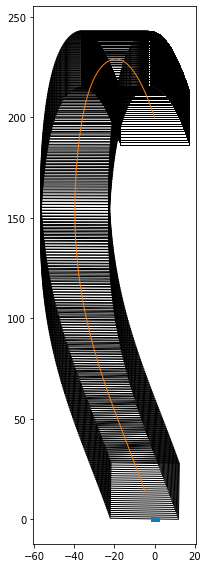

[[ 1.11254e+01  1.06972e+01 -1.58830e+01]
 [ 1.10869e+01  1.06815e+01 -1.58254e+01]
 [ 1.10499e+01  1.06669e+01 -1.57676e+01]
 ...
 [ 5.48800e-01  5.76500e-01 -5.81350e+00]
 [ 2.78700e-01  2.93000e-01 -3.27060e+00]
 [-0.00000e+00  1.00000e-04 -3.31000e-02]]


In [ ]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    # First forward rollout
    u_trj = np.random.randn(N-1, n_u)*0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 100
    min_regu = 0.01
    
    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]
    
    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)

        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break
            
    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace

# Setup problem and call iLQR
x0s = [np.array([dest[0], -30, 200, 0, 0, 0]), np.array([dest[0], 20, 200, 0, 0, 0]), np.array([dest[0], -10, 200, 30, 0, 0])]
for x0 in x0s:
    # x0 = dest_
    N = 3000
    max_iter = 50
    regu_init = 10
    x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(x0, N, max_iter, regu_init)
    print(regu_trace)

    end = N - 1
    for n in range(N):
        if x_trj[n, 2] < dest[1] + h/2:
            print(x_trj[n, 2])
            end = n + 1
            break
    print(f"end = {end}")
    plt.figure(figsize=(9.5,8))
    # Plot circle
    helipad_x = np.linspace(-1, 1, 50) + dest[0]
    helipad_y = np.zeros(helipad_x.shape) + dest[1]
    plt.plot(helipad_x, helipad_y, linewidth=5)
    ax = plt.gca()

    # Plot resulting trajecotry of car
    plt.plot(x_trj[:end,0], x_trj[:end,2], linewidth=1)

    # Plot rectangles
    for n in range(0, end, 5):
        rect = mpl.patches.Rectangle((-w/2,-h/2), w, h, fill=False)
        t = mpl.transforms.Affine2D().rotate(x_trj[n,4]).translate(x_trj[n,0], x_trj[n,2]) + ax.transData
        rect.set_transform(t)
        ax.add_patch(rect)
    ax.set_aspect(1)
    #plt.ylim((-3, 15))
    #plt.xlim((-5, 5))
    plt.tight_layout()
    plt.show()
    print(u_trj.round(4))

In [ ]:
print(np.array([cost_stage(x, u) for x, u in zip(x_trj, u_trj)]))

[1418.93999741 1410.50804147 1402.12033476 ...  -76.91411355  -79.84746258
  -82.19556048]


In [ ]:
u_trj.max()

11.125424170493881

In [ ]:
print(x_trj.round(4))

[[ 0.000000e+00 -1.000000e+01  2.000000e+02  3.000000e+01  0.000000e+00
   0.000000e+00]
 [-1.000000e-01 -1.000000e+01  2.003000e+02  2.984410e+01  0.000000e+00
   0.000000e+00]
 [-2.000000e-01 -1.000000e+01  2.005984e+02  2.968830e+01  0.000000e+00
   0.000000e+00]
 ...
 [ 4.932400e+00  4.327900e+00 -4.127850e+01  1.200000e+01 -3.700000e-02
  -1.200000e-03]
 [ 4.975700e+00  4.327400e+00 -4.115850e+01  1.188690e+01 -3.700000e-02
  -1.200000e-03]
 [ 5.018900e+00  4.335300e+00 -4.103960e+01  1.200100e+01 -3.700000e-02
  -1.200000e-03]]


In [ ]:
print(np.diff(x_trj, axis=0).round(4))

[[-0.1    -0.      0.3    -0.1559  0.      0.    ]
 [-0.1    -0.      0.2984 -0.1559  0.      0.    ]
 [-0.1    -0.      0.2969 -0.1559  0.      0.    ]
 ...
 [ 0.0433 -0.0011  0.1213 -0.1334 -0.     -0.    ]
 [ 0.0433 -0.0004  0.12   -0.1131 -0.     -0.    ]
 [ 0.0433  0.0078  0.1189  0.1141 -0.     -0.    ]]


In [ ]:
print(u_trj.max())

11.125424170493881


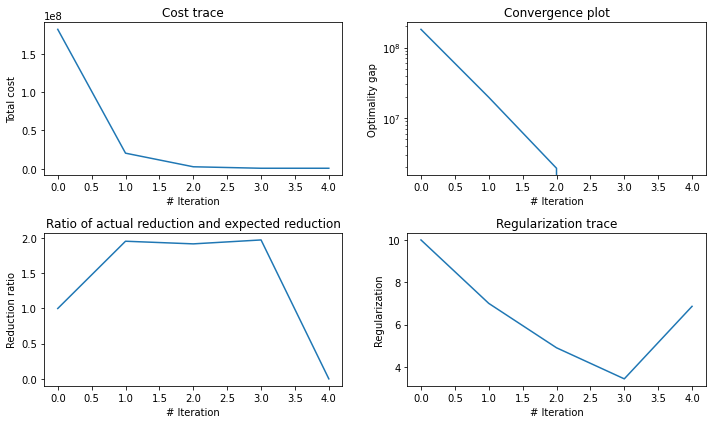

In [ ]:
plt.subplots(figsize=(10,6))
# Plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel('# Iteration')
plt.ylabel('Total cost')
plt.title('Cost trace')

plt.subplot(2, 2, 2)
delta_opt = (np.array(cost_trace) - cost_trace[-1])
plt.plot(delta_opt)
plt.yscale('log')
plt.xlabel('# Iteration')
plt.ylabel('Optimality gap')
plt.title('Convergence plot')

plt.subplot(2, 2, 3)
plt.plot(redu_ratio_trace)
plt.title('Ratio of actual reduction and expected reduction')
plt.ylabel('Reduction ratio')
plt.xlabel('# Iteration')

plt.subplot(2, 2, 4)
plt.plot(regu_trace)
plt.title('Regularization trace')
plt.ylabel('Regularization')
plt.xlabel('# Iteration')
plt.tight_layout()

### Convergence Analysis
You can find some plots of the convergence traces captured throughout the iLQR solve process above. The convergence plot indicates that we have achieved superlinear convergence. In fact, iLQR achieves nearly second order convergence. In the case of linear convergence (e.g. gradient descent), the [graph would show a line](https://en.wikipedia.org/wiki/Rate_of_convergence). While the integrated regularization improves robustness it damps convergence in the early iteration steps. 

In the ideal case, the expected reduction and the actual reduction should be the same, i.e. the reduction ratio remains around 1. If that is the case, the quadratic approximation of costs and linear approximation of the dynamics are very accurate. If the ratio becomes significantly lower than 1, the regularization needs to be increased and thus the stepsize reduced.

## Heuristic Function

In [ ]:
u_trj[-1400:]

array([[ 9.60574621e-01, -8.58294958e-01, -8.78764375e-01],
       [ 9.56865401e-01, -8.54345991e-01, -8.78556306e-01],
       [ 9.52815802e-01, -8.50631431e-01, -8.78609758e-01],
       ...,
       [ 5.48818346e-01,  5.76519368e-01, -5.81349922e+00],
       [ 2.78683219e-01,  2.92993197e-01, -3.27057597e+00],
       [-3.05966149e-05,  7.47476038e-05, -3.30852964e-02]])